In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [23]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

#  Data collection, visualization  and preprocessing

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Dataset",
    shuffle=True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)

68

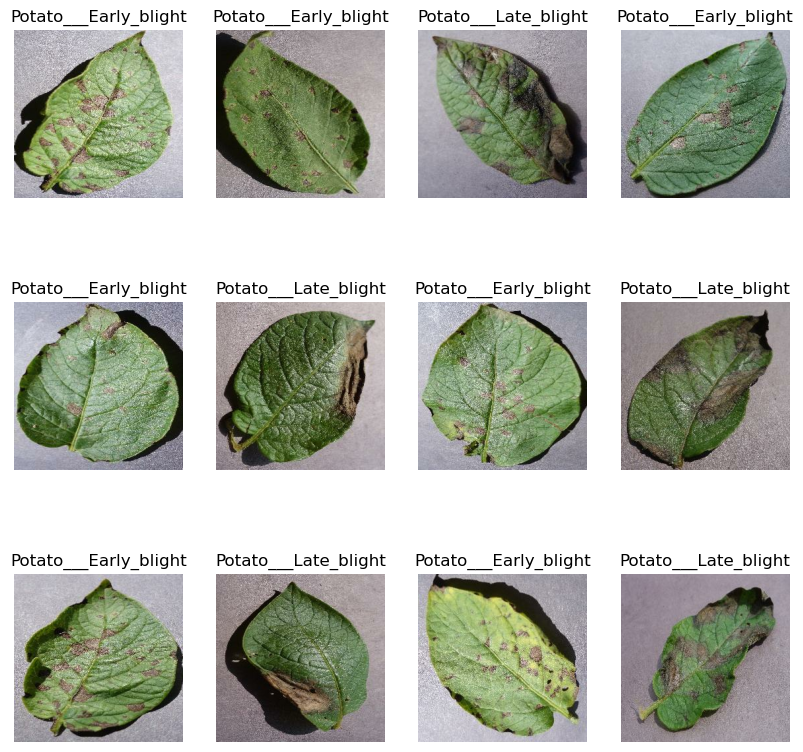

In [6]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")
    

In [ ]:
80% ==> training
20% ==> 10% validation, 10% test

In [7]:
training_size = 0.8
len(dataset) * training_size

54.400000000000006

In [8]:
train_ds = dataset.take(54)
len(train_ds)

54

In [9]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [10]:
value_size = 0.1
len(dataset)*value_size

6.800000000000001

In [11]:
value_ds = test_ds.take(6)
len(value_ds)

6

In [12]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [13]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size = 10000):
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds,val_ds, test_ds

In [14]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [15]:
len(train_ds)

54

In [16]:
len(val_ds)

6

In [17]:
len(test_ds)

8

In [18]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [20]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [21]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

# Model building

In [26]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [27]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (32, 127, 127, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (32, 60, 60, 64)         

# Compiling the model

In [28]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [29]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/50
54/54 [==============================] - 141s 2s/step - loss: 0.9059 - accuracy: 0.4688 - val_loss: 0.8431 - val_accuracy: 0.4896
Epoch 2/50
54/54 [==============================] - 140s 3s/step - loss: 0.7278 - accuracy: 0.6377 - val_loss: 0.5955 - val_accuracy: 0.6979
Epoch 3/50
54/54 [==============================] - 111s 2s/step - loss: 0.4966 - accuracy: 0.7714 - val_loss: 0.3783 - val_accuracy: 0.8490
Epoch 4/50
54/54 [==============================] - 112s 2s/step - loss: 0.3674 - accuracy: 0.8339 - val_loss: 0.3006 - val_accuracy: 0.8698
Epoch 5/50
54/54 [==============================] - 115s 2s/step - loss: 0.2820 - accuracy: 0.8848 - val_loss: 0.3862 - val_accuracy: 0.8438
Epoch 6/50
54/54 [==============================] - 112s 2s/step - loss: 0.2425 - accuracy: 0.9097 - val_loss: 0.2852 - val_accuracy: 0.8750
Epoch 7/50
54/54 [==============================] - 111s 2s/step - loss: 0.1860 - accuracy: 0.9294 - val_loss: 0.4830 - val_accuracy: 0.8281
Epoch 8/50
54

In [30]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 6s 376ms/step - loss: 0.0188 - accuracy: 0.9961


In [31]:
scores

[0.018815962597727776, 0.99609375]

In [32]:
history

In [33]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [34]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [35]:
history.history['accuracy']

[0.46875,
 0.6377314925193787,
 0.7714120149612427,
 0.8339120149612427,
 0.8848379850387573,
 0.9097222089767456,
 0.9293981194496155,
 0.9438657164573669,
 0.9513888955116272,
 0.9664351940155029,
 0.9814814925193787,
 0.9710648059844971,
 0.9866898059844971,
 0.96875,
 0.9913194179534912,
 0.9994212985038757,
 1.0,
 1.0,
 1.0,
 0.9594907164573669,
 0.9890046119689941,
 0.9913194179534912,
 0.9809027910232544,
 0.9965277910232544,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

In [36]:
type(history.history['loss'])

list

In [37]:
len(history.history['loss'])

50

In [38]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.9059261083602905,
 0.7277674674987793,
 0.4965968430042267,
 0.36739763617515564,
 0.28201061487197876]

In [39]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

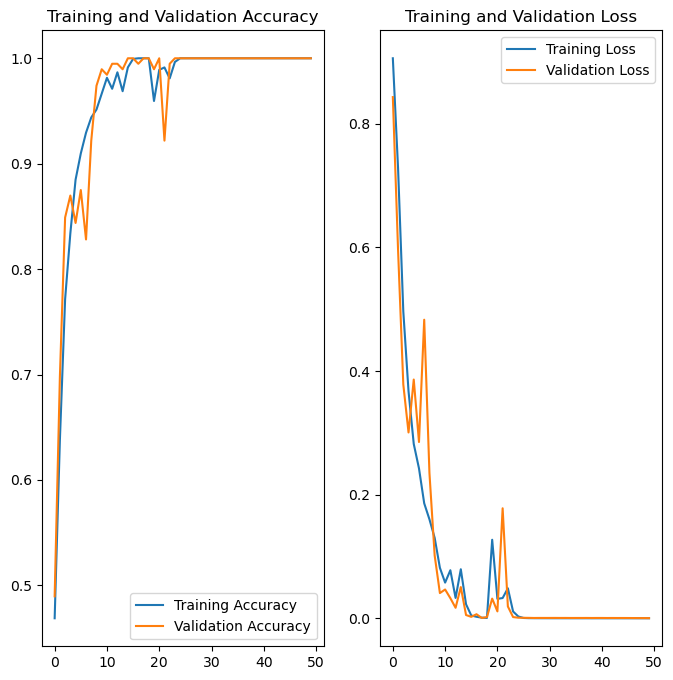

In [40]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Prediction

first image to predict
actual label: Potato___Late_blight
1/1 [==============================] - 0s 446ms/step
predicted label: Potato___Late_blight


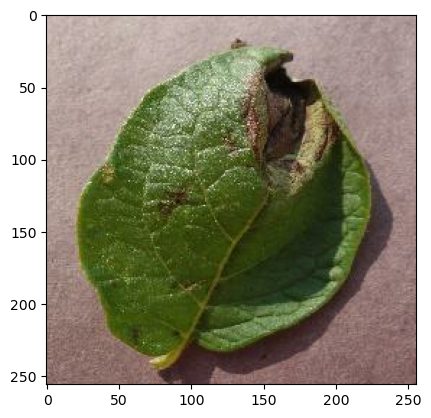

In [44]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [45]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 34ms/step


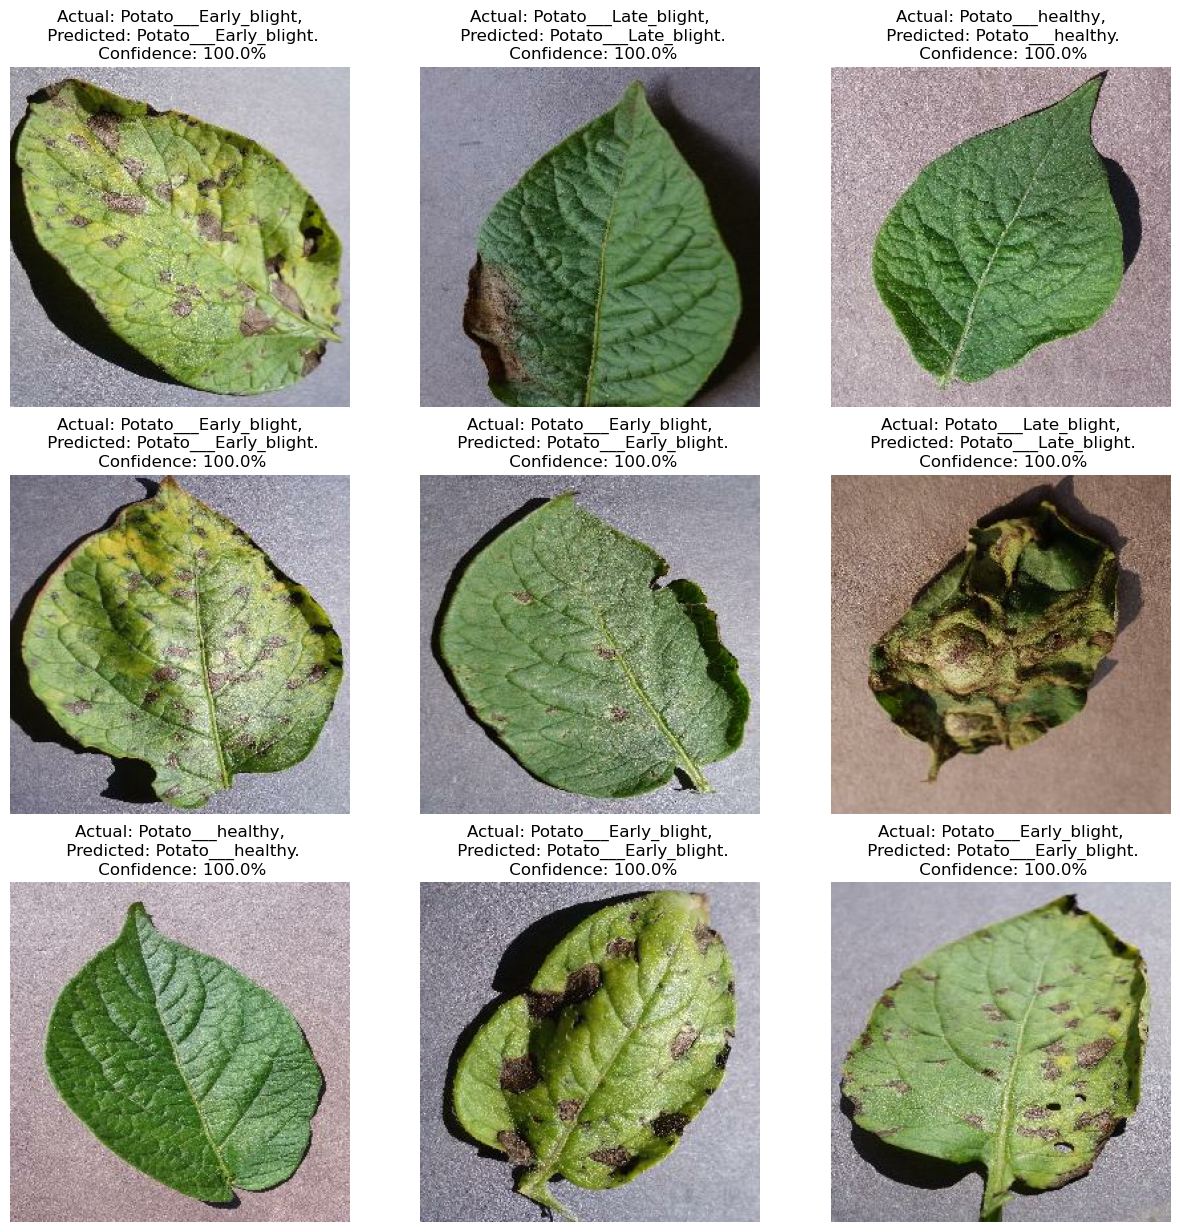

In [46]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

# Saving the model

In [47]:
import os
model_version=max([int(i) for i in os.listdir("../Models") + [0]])+1
model.save(f"../Models/{model_version}")

INFO:tensorflow:Assets written to: ../Models/1\assets


INFO:tensorflow:Assets written to: ../Models/1\assets
